
--- Feature Map Circuit ---
0: ──H──RZ(5.70)─╭●────────────╭●──────────────────────────────────┤  State
1: ──H──RZ(2.90)─╰X──RZ(16.53)─╰X─╭●────────────╭●─────────────────┤  State
2: ──H──RZ(4.20)──────────────────╰X──RZ(12.18)─╰X─╭●───────────╭●─┤  State
3: ──H──RZ(1.30)───────────────────────────────────╰X──RZ(5.46)─╰X─┤  State

--- Kernel Circuit ---
0: ──H──RZ(5.70)─╭●────────────╭●───────────────────────────────────────────────────── ···
1: ──H──RZ(2.90)─╰X──RZ(16.53)─╰X─╭●────────────╭●──────────────────────────────────── ···
2: ──H──RZ(4.20)──────────────────╰X──RZ(12.18)─╰X─╭●───────────╭●─╭X†─────────────╭X† ···
3: ──H──RZ(1.30)───────────────────────────────────╰X──RZ(5.46)─╰X─╰X†──RZ(13.86)†─╰X† ···

0: ··· ────────────────────────────╭X†────────────────────╭X†──RZ(7.60)†──H†─┤ ╭Probs
1: ··· ─╭X†────────────────────╭X†─╰X†─────────RZ(22.80)†─╰X†──RZ(3.00)†──H†─┤ ├Probs
2: ··· ─╰X†─────────RZ(19.80)†─╰X†──RZ(6.60)†──H†────────────────────────────┤ ├Probs
3: ··· ──RZ(2.10)†──

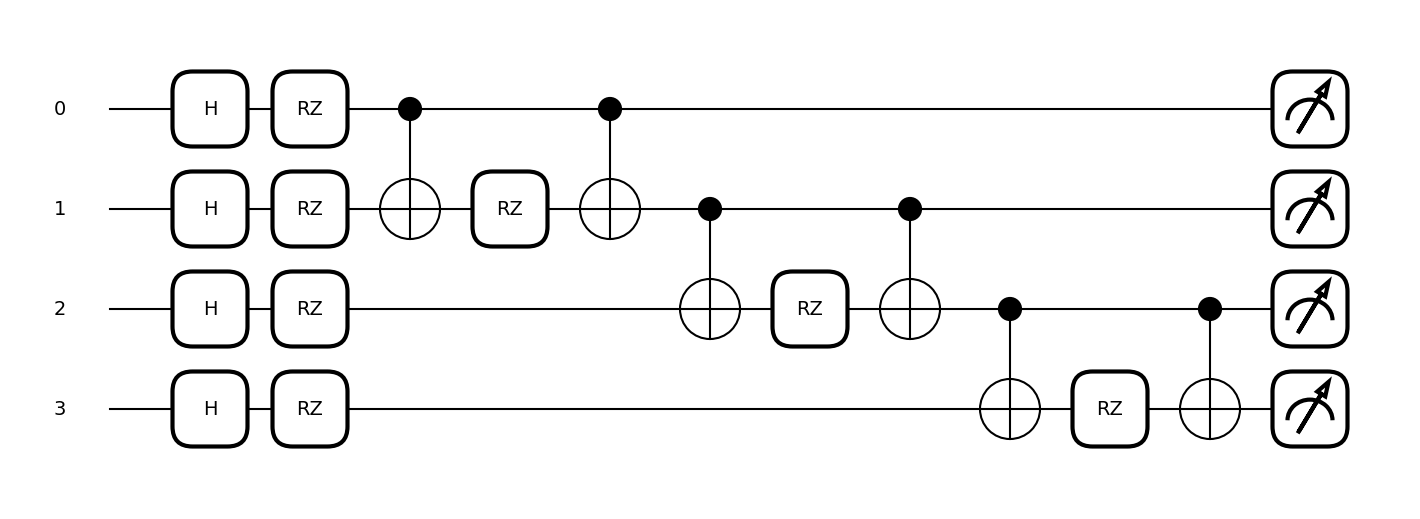


--- Kernel Circuit ---


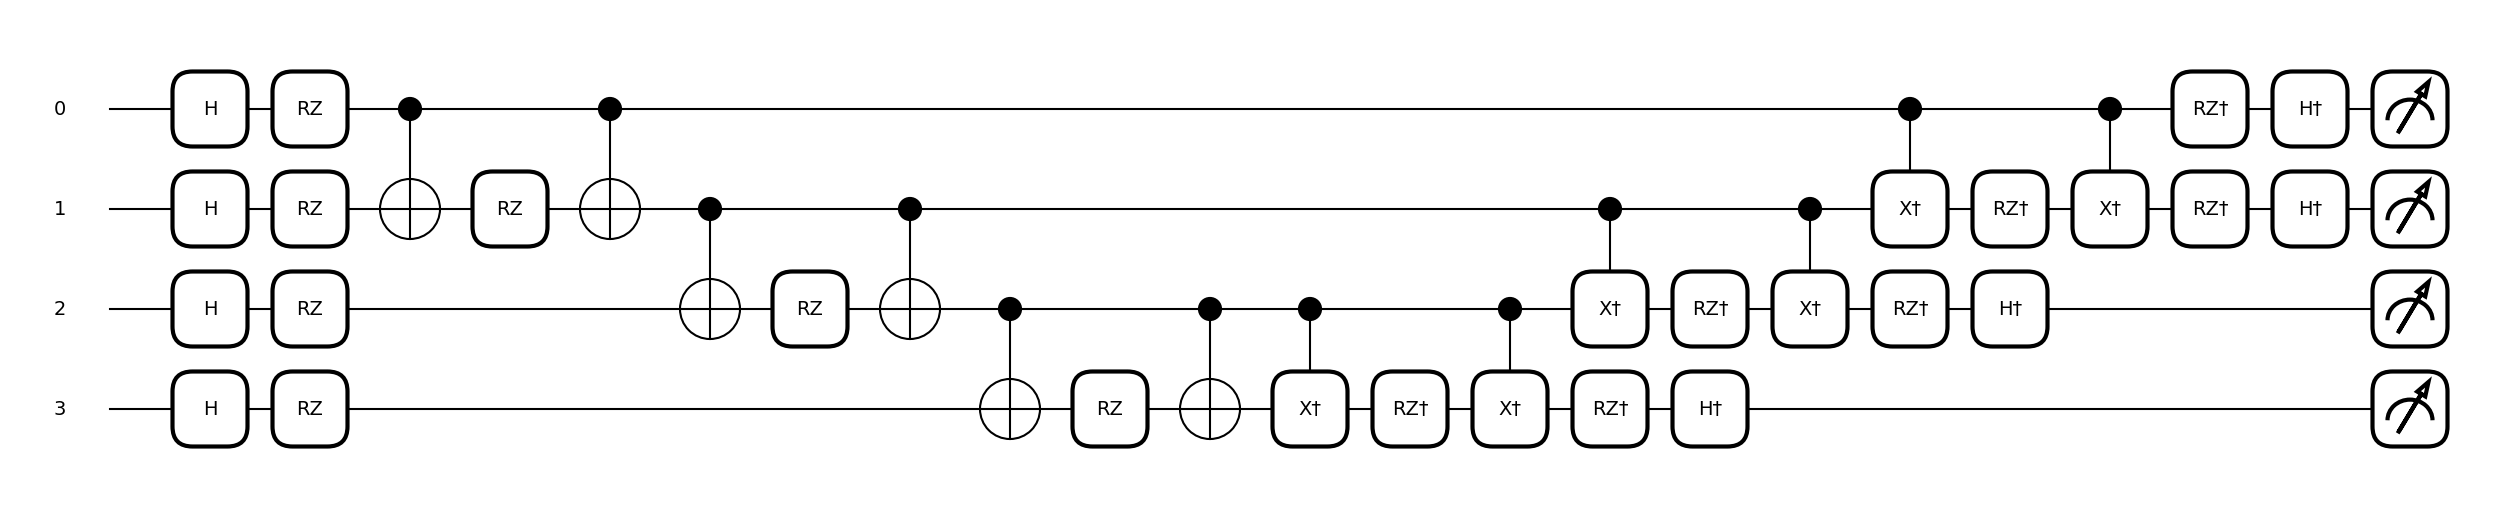


Confusion Matrix
[[19  0  0]
 [ 0 15  0]
 [ 0  2 14]]

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.88      1.00      0.94        15
           2       1.00      0.88      0.93        16

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50

Predicted flower type for (4.4, 4.4, 4.4, 4.4): 2


In [ ]:
  import pennylane as qml
from pennylane import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
data = load_iris(as_frame=True)
df_iris = data.frame
X = df_iris[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].values
y = df_iris['target'].values


encoder = LabelEncoder()
y = encoder.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

def feature_map(x):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RZ(x[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])
        qml.RZ((x[i] * x[i+1]), wires=i+1)
        qml.CNOT(wires=[i, i+1])

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    feature_map(x1)
    qml.adjoint(feature_map)(x2)
    return qml.probs(wires=range(n_qubits))

sample_x = x_train[0]
sample_y = x_train[1]

@qml.qnode(dev)
def feature_map_circuit(x):
    feature_map(x)
    return qml.state()

print("\n--- Feature Map Circuit ---")
print(qml.draw(feature_map_circuit)(sample_x))

print("\n--- Kernel Circuit ---")
print(qml.draw(kernel_circuit)(sample_x, sample_y))

print("\n--- Feature Map Circuit ---")
fig, ax = qml.draw_mpl(feature_map_circuit)(sample_x)
plt.show()

print("\n--- Kernel Circuit ---")
fig, ax = qml.draw_mpl(kernel_circuit)(sample_x, sample_y)
plt.show()

def kernel(x1, x2):
    return kernel_circuit(x1, x2)[0]

def compute_kernel_matrix(X1, X2):
    K = np.zeros((len(X1), len(X2)))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            K[i, j] = kernel(x1, x2)
    return K

K_train = compute_kernel_matrix(x_train, x_train)
K_test = compute_kernel_matrix(x_test, x_train)

qsvm_model = SVC(kernel="precomputed")
qsvm_model.fit(K_train, y_train)

y_pred = qsvm_model.predict(K_test)
print("\nConfusion Matrix")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report")
#print(classification_report(y_test, y_pred, target_names=encoder.classes_))
print(classification_report(y_test, y_pred, target_names=[str(c) for c in encoder.classes_]))


new_point = np.array([[4.4, 4.4, 4.4, 4.4]])
K_new = compute_kernel_matrix(new_point, x_train)
pred_label = qsvm_model.predict(K_new)
print("Predicted flower type for (4.4, 4.4, 4.4, 4.4):", encoder.inverse_transform(pred_label)[0])
